<a href="https://colab.research.google.com/github/Dimka322/tasks/blob/main/shade_gray_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Пьянков Дмитрий

Для решения поставленной задачи я подобрал несколько вариантов построения маски, рассмотренных ниже


1.   Построение обычной маски
2.   Построение широкой маски
3.   Построение обычной трапеции
4.   Построение широкой трапеции



In [1]:
import os

In [71]:
from PIL import Image, ImageFilter

In [2]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [99]:
img = cv2.imread('/content/48365_00.png')

In [100]:
img.shape

(1024, 768, 3)

In [ ]:
cv2_imshow(img)

Так как на вход алгоритма поступает, размеченное на классы, изображение, то соответствующие классы можно окрасить в нужный цвет.
Выходом функции является окрашенное изображение и координаты для построения трапеции в будущем.

In [136]:
def convert_original_mask_to_gray(img):
  img_ = img.copy()
  left_leg_x, left_leg_y = img.shape[0], img.shape[1]
  right_leg_x, right_leg_y = 0, 0
  bottom_leg_x, bottom_leg_y = img.shape[0] / 2, img.shape[1] / 2
  for x in range(img.shape[0]):
    for y in range(img.shape[1]):
      if (np.array_equal(img[x, y], [0, 192, 128]) \
          or np.array_equal(img[x, y], [0, 192, 0])) \
          and (x < bottom_leg_x) and (y<bottom_leg_y):
        bottom_leg_x, bottom_leg_y = x, y
        img_[x, y] = [0, 0, 0]
      elif (not np.array_equal(img[x, y], [128, 0, 64])) \
          and (not np.array_equal(img[x, y], [0, 64, 128])) \
          and (not np.array_equal(img[x, y], [0, 0, 64])) \
          and (not np.array_equal(img[x, y], [0, 64, 0])) :
        img_[x, y] = [0, 0, 0]
      else:
        if np.array_equal(img[x, y], [0, 64, 128]) and (x <= left_leg_x) and(y <= left_leg_y):
          left_leg_x, left_leg_y = x, y
        if np.array_equal(img[x, y], [0, 64, 0]) and (x >= right_leg_x) and (y >= right_leg_y):
          right_leg_x, right_leg_y = x, y
        if (np.array_equal(img[x, y], [0, 0, 64])  \
        or np.array_equal(img[x, y], [0, 64, 128]) or np.array_equal(img[x, y], [0, 64, 0])) \
          and x > bottom_leg_y:
          bottom_leg_y = x
        img_[x, y] = [143, 141, 141]

  return img_, left_leg_x, left_leg_y, right_leg_x, right_leg_y, bottom_leg_x, bottom_leg_y

In [137]:
img_, left_leg_x, left_leg_y, right_leg_x, right_leg_y, bottom_leg_x, bottom_leg_y = convert_original_mask_to_gray(img)

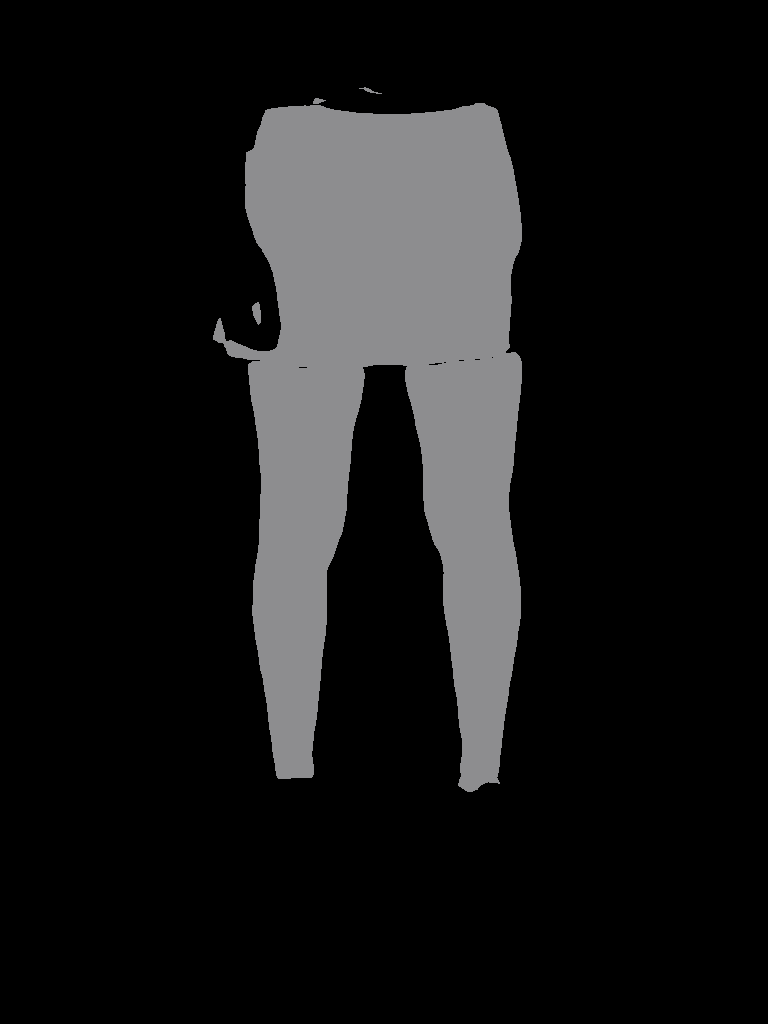

In [138]:
cv2_imshow(img_)

На данном варианте решения можно заметить черные пиксели в области серого цвета, либо же возможен вариант, когда серые пиксели находятся вдали от основного контура. Данную проблему можно в определенном роде решить сжатием-расширением.

In [139]:
def erode(cycles, image):
    for _ in range(cycles):
         image = image.filter(ImageFilter.MinFilter(3))
    return image


def dilate(cycles, image):
    for _ in range(cycles):
         image = image.filter(ImageFilter.MaxFilter(3))
    return image

In [140]:
def erode_and_dilate(img: np.array, cycle_1=12, cycle_2=22):
  image_pillow = Image.fromarray(img)
  step_1_erode = erode(cycle_1, image_pillow)
  step_2_dilate = dilate(cycle_2, step_1_erode)
  img_step_2 = np.array(step_2_dilate)
  return img_step_2

In [141]:
img_2 = erode_and_dilate(img_)

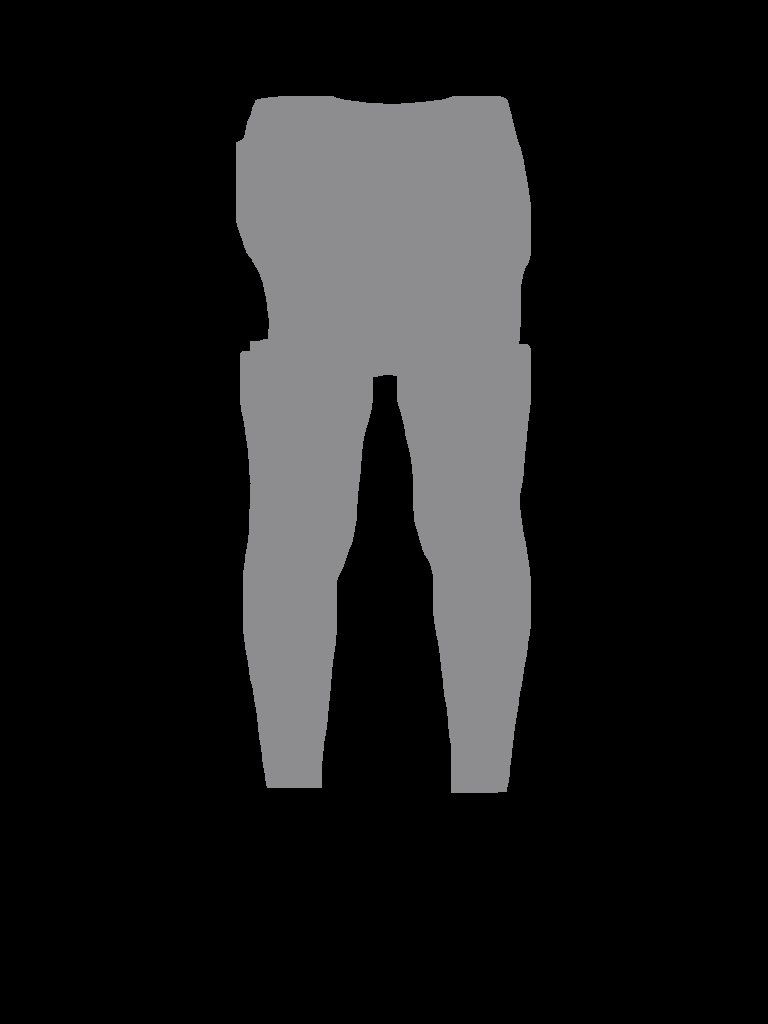

In [142]:
cv2_imshow(img_2)

Можно заметить, что контур стал шире, но при этом сама область выглядит четкой и без пропусков внутри.

Попробуем оформить контур в виде трапеции

In [165]:
def try_trapezoid(img: np.array):
  img_ = img.copy()
  for x in range(img.shape[0]):
    for y in range(img.shape[1]):
      if (x >= left_leg_x and y >= left_leg_y) \
      and (x >= right_leg_x and y <= right_leg_y) and (x <= bottom_leg_y):
        img_[x, y] = [143, 141, 141]
      else:
        img_[x, y] = img[x, y]

  return img_

In [166]:
img_3 = try_trapezoid(img_2)

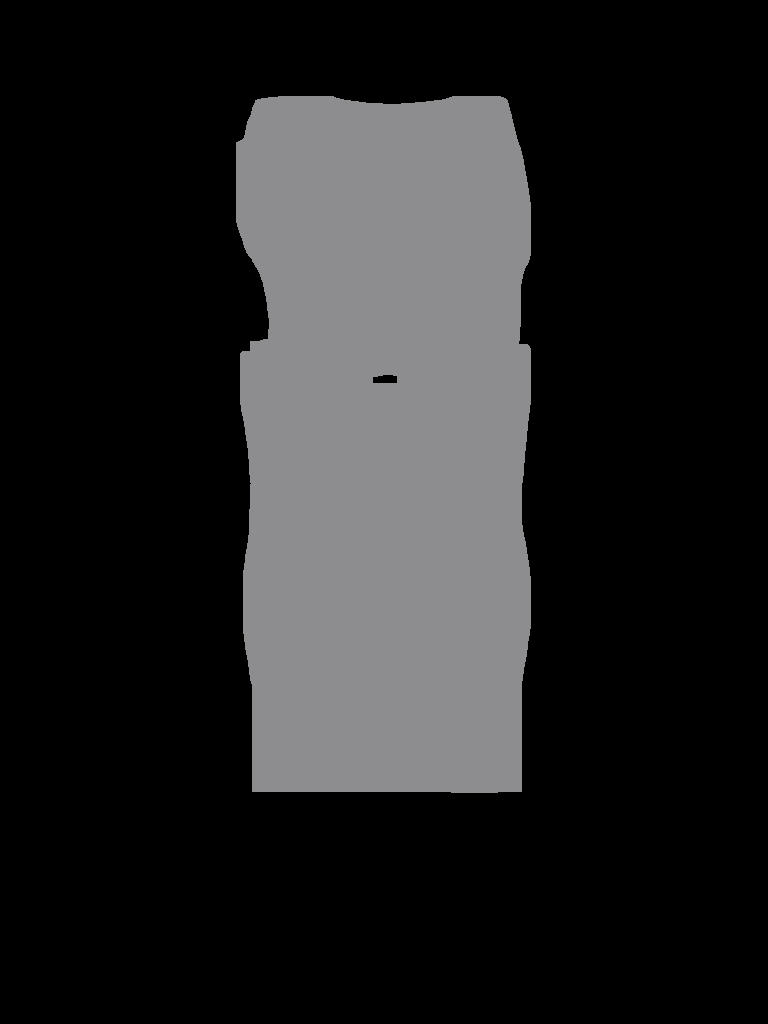

In [167]:
cv2_imshow(img_3)

Можно заметить те же черные пиксели посреди серых, что были ранее. Применим функцию сужения-расширения.

In [146]:
img_4 = erode_and_dilate(img_3)

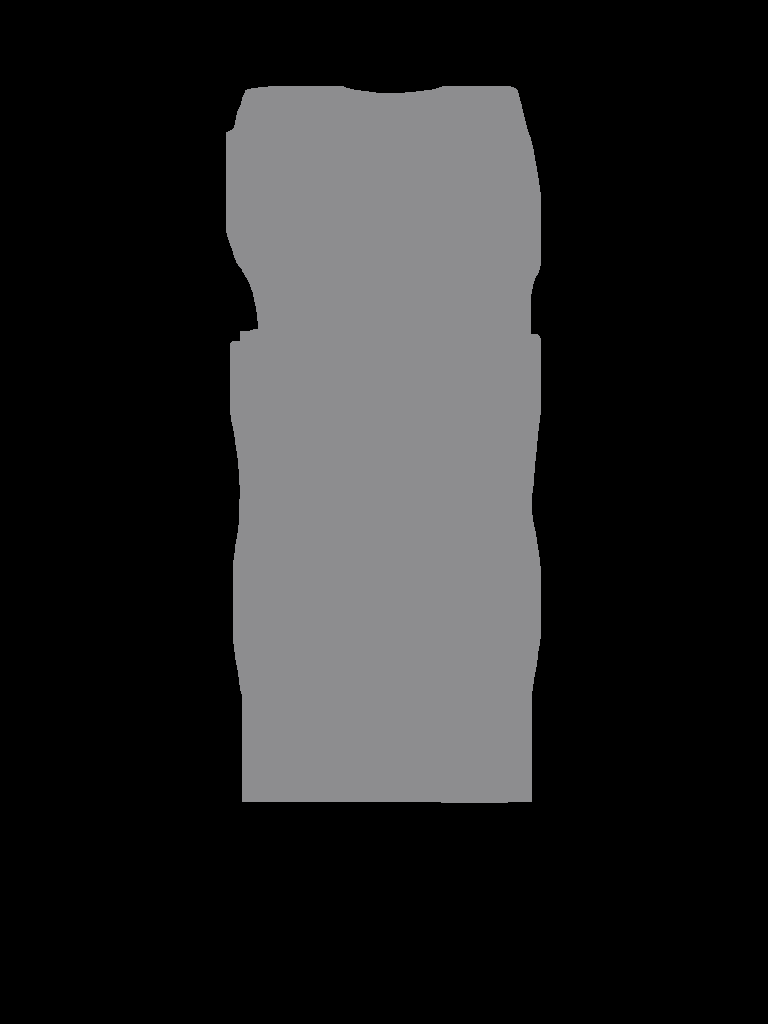

In [147]:
cv2_imshow(img_4)

После процедуры сужения-расширения область ниже юбки приняла прямоугольный вид

In [148]:
original_image = cv2.imread('/content/48365_00.jpg')

In [150]:
def check_mask(original_image: np.array, mask: np.array):
  original_ = mask.copy()
  for x in range(mask.shape[0]):
    for y in range(mask.shape[1]):
      if np.array_equal(mask[x, y], [0, 0, 0]):
        original_[x, y] = original_image[x, y]
      else:
        original_[x, y] = mask[x, y]

  return original_

In [168]:
original_mask = check_mask(original_image, img_)
original_mask_2 = check_mask(original_image, img_2)
original_mask_3 = check_mask(original_image, img_3)
original_mask_4 = check_mask(original_image, img_4)

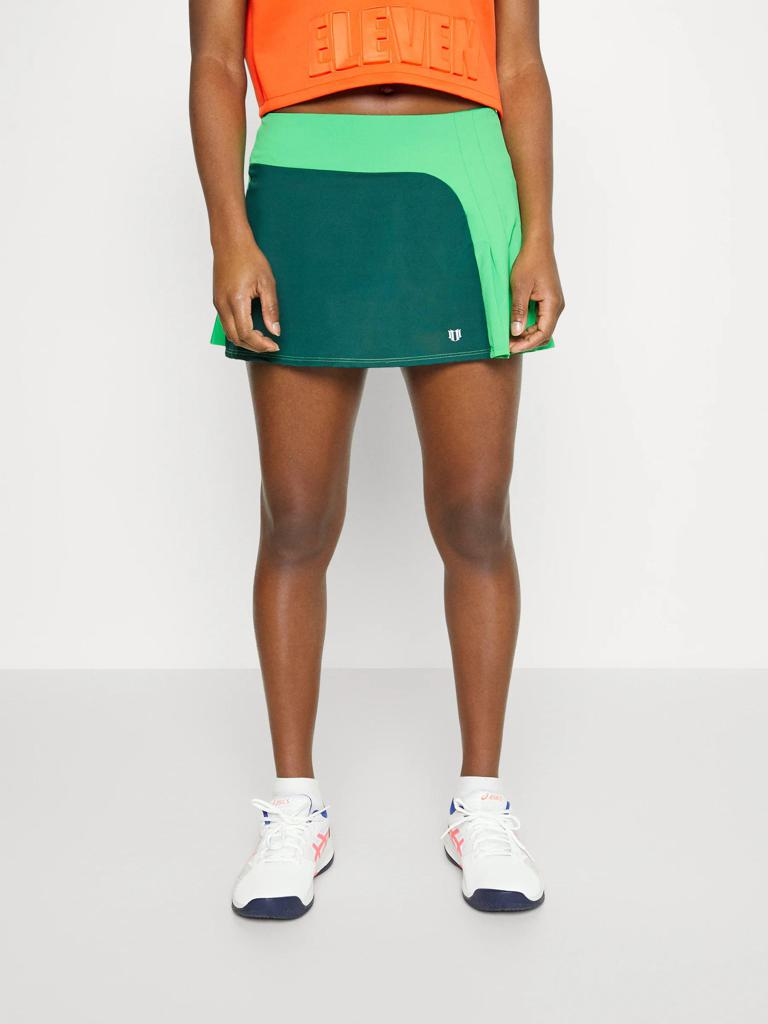

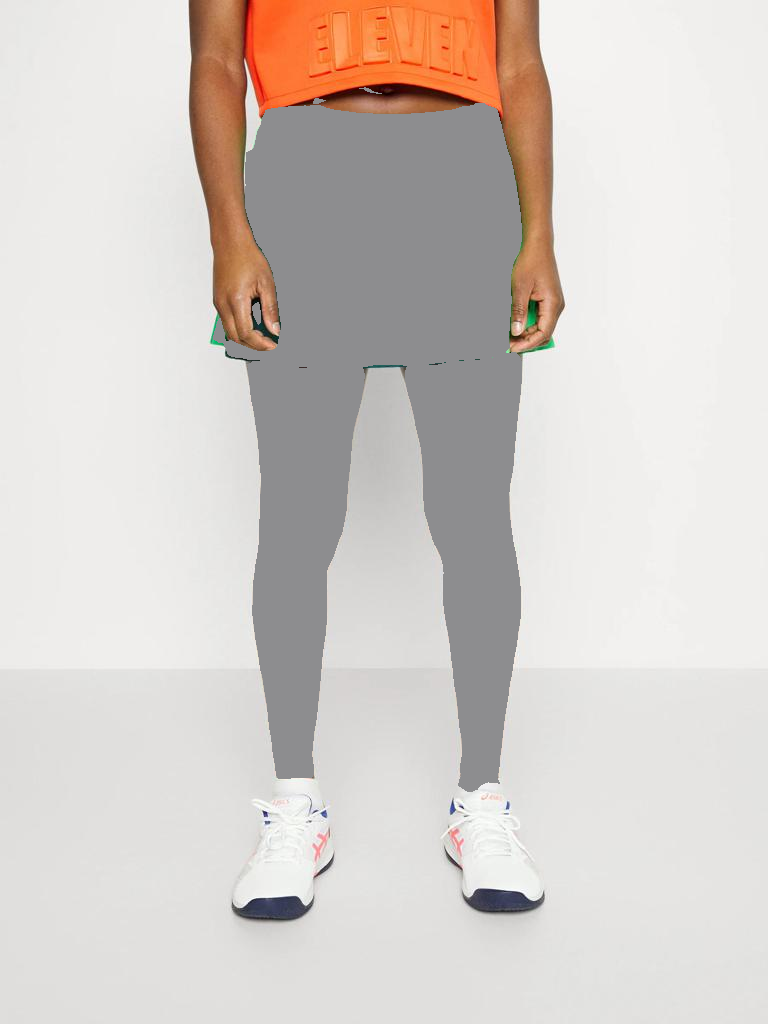

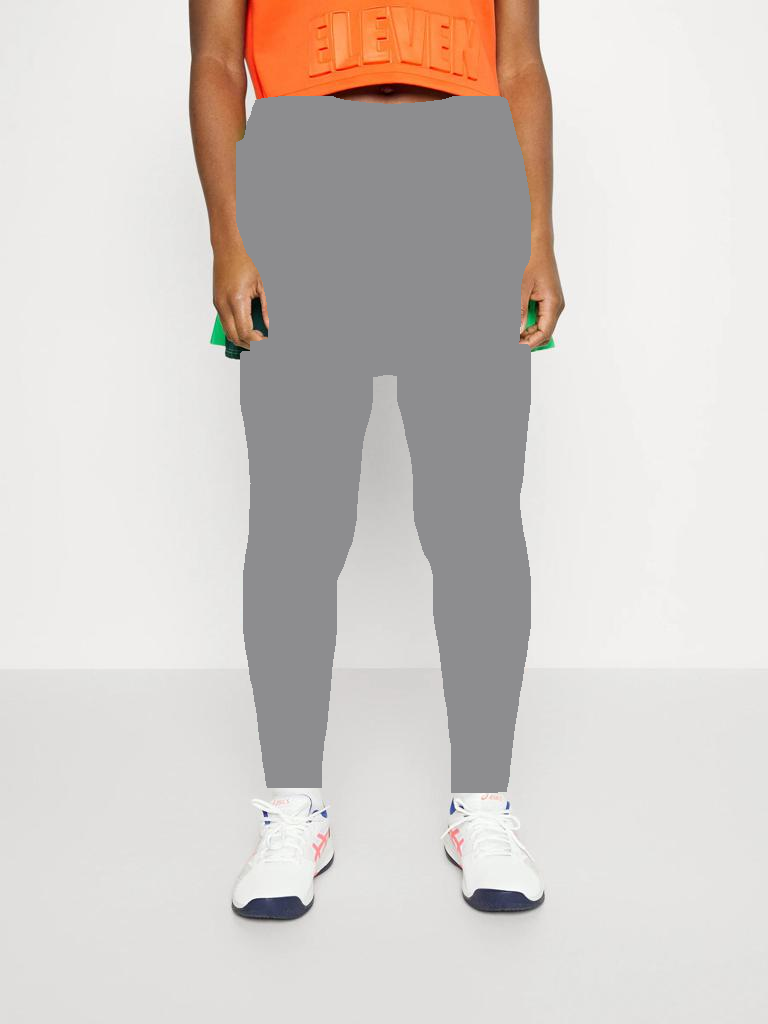

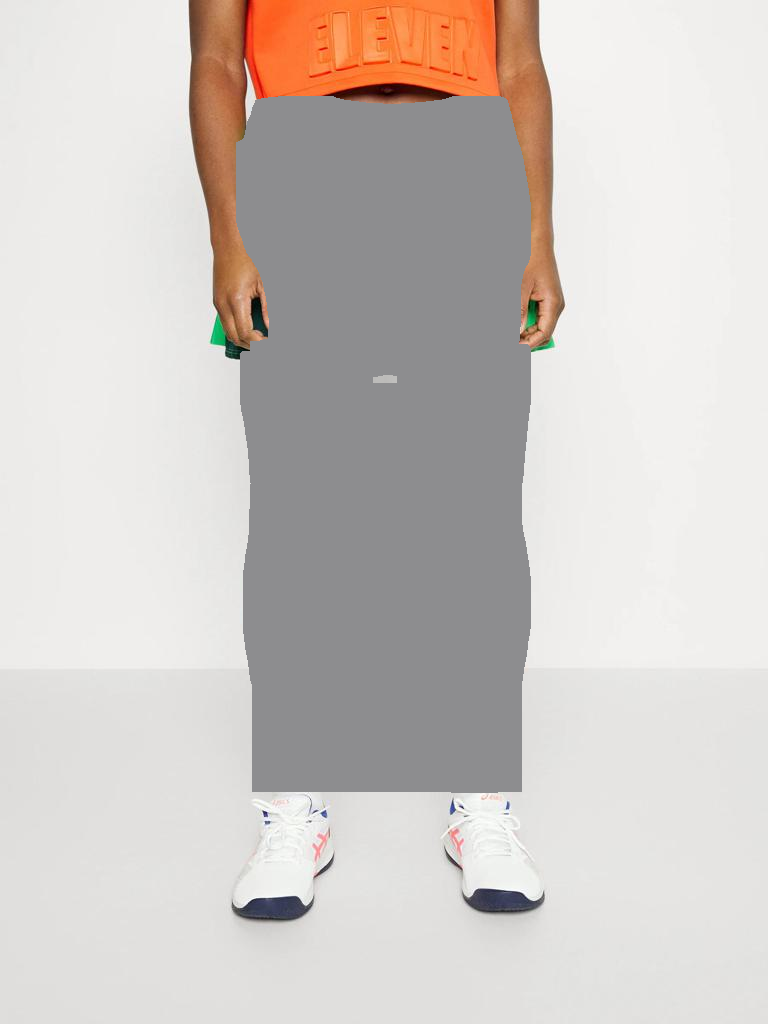

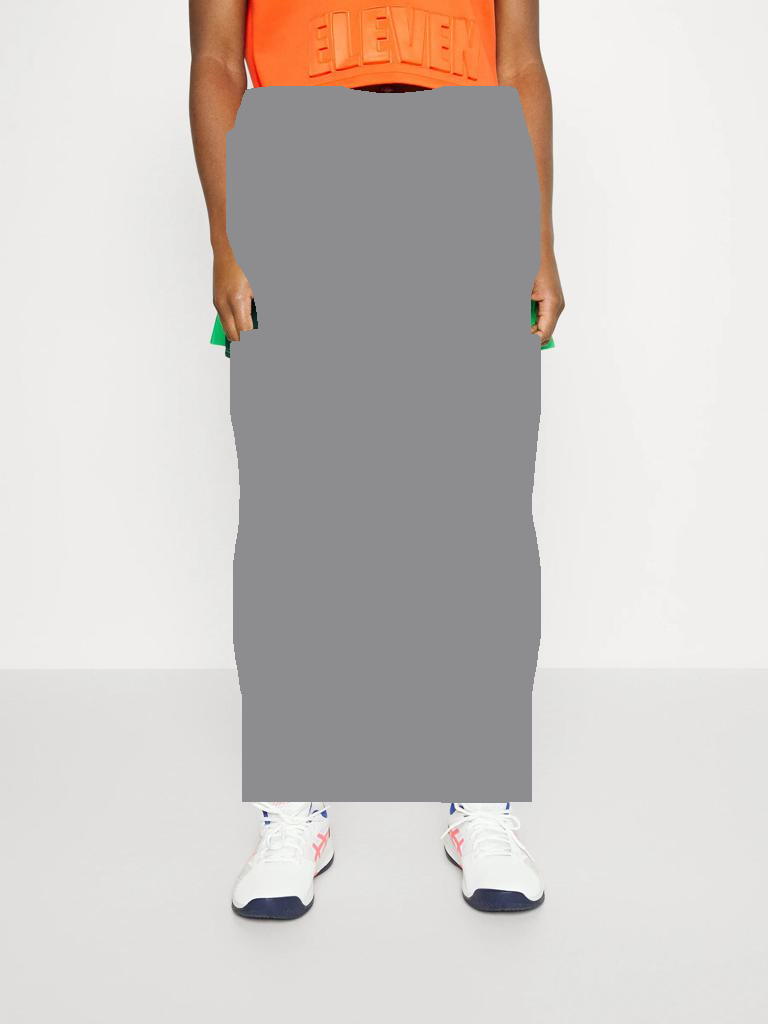

In [169]:
cv2_imshow(original_image)
cv2_imshow(original_mask)
cv2_imshow(original_mask_2)
cv2_imshow(original_mask_3)
cv2_imshow(original_mask_4)

По моему мнению, наилучшим вариантом является маска из второго варианта, потому что в ней отсутсвуют пропуски внутри серой области, а также отсутствуют серые пиксели вне серой области.


Основная проблема с построением трапеции связана с тем, что, в зависимости от позы, координаты ног и стоп меняются, что порождает слишком большие пропуски внутри серой зоны, которые не удается устранить расширением-сужением.